# Bibliotheken importieren

In [1]:
#pip install scikit-learn

In [2]:
# Bibliotheken importieren

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model  import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import r2_score, mean_absolute_error


#import xgboost as xgb
#from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV # new import we need for this week

# Daten laden

In [3]:
df_train_clean = pd.read_parquet("df_train_ML_ready.parquet")

# Optional: kurz prüfen
print(df_train_clean.head())

        date        id  store_nbr  item_nbr  unit_sales  onpromotion  \
0 2014-02-21  19281571         24    103520         2.0        False   
1 2014-02-22  19331514         24    103520         8.0        False   
2 2014-02-23  19382503         24    103520         3.0        False   
3 2014-02-24  19432532         24    103520         1.0        False   
4 2014-02-25  19481433         24    103520         6.0        False   

   is_outlier  year  month  day  ...  holiday_transferred transactions  lag_7  \
0       False  2014      2   21  ...                    0       2455.0   10.0   
1       False  2014      2   22  ...                    0       2291.0   10.0   
2       False  2014      2   23  ...                    0       1419.0    8.0   
3       False  2014      2   24  ...                    0       2247.0    4.0   
4       False  2014      2   25  ...                    0       2192.0    2.0   

   lag_30  lag_364 rolling_7d_std rolling_30d_std rolling_7d_mean  \
0     3.0  

In [4]:
df_train_clean.columns

Index(['date', 'id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'is_outlier', 'year', 'month', 'day', 'day_of_week', 'family',
       'item_class', 'perishable', 'dcoilwtico', 'city', 'state', 'store_type',
       'sim_store_cluster', 'holiday_type', 'holiday_locale',
       'holiday_locale_name', 'holiday_description', 'holiday_transferred',
       'transactions', 'lag_7', 'lag_30', 'lag_364', 'rolling_7d_std',
       'rolling_30d_std', 'rolling_7d_mean', 'rolling_30d_mean', 'is_weekend'],
      dtype='object')

In [5]:
df_train_clean.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,year,month,day,...,holiday_transferred,transactions,lag_7,lag_30,lag_364,rolling_7d_std,rolling_30d_std,rolling_7d_mean,rolling_30d_mean,is_weekend
0,2014-02-21,19281571,24,103520,2.0,False,False,2014,2,21,...,0,2455.0,10.0,3.0,6.0,6.658328,9.693522,9.000000,11.633333,0
1,2014-02-22,19331514,24,103520,8.0,False,False,2014,2,22,...,0,2291.0,10.0,3.0,16.0,2.751623,2.725992,5.714286,6.500000,1
2,2014-02-23,19382503,24,103520,3.0,False,False,2014,2,23,...,0,1419.0,8.0,4.0,7.0,18.442962,14.250791,22.142857,23.133333,1
3,2014-02-24,19432532,24,103520,1.0,False,False,2014,2,24,...,0,2247.0,4.0,5.0,1.0,3.716117,2.725782,4.857143,4.466667,0
4,2014-02-25,19481433,24,103520,6.0,False,False,2014,2,25,...,0,2192.0,2.0,4.0,2.0,11.338934,11.418074,31.714286,32.800000,0


In [6]:
df_train_clean["perishable"].unique()

array([0])

In [7]:
df_train_clean["city"].unique()

array(['Guayaquil', 'Daule', 'Playas', 'Libertad'], dtype=object)

In [8]:
df_train_clean["state"].unique()

array(['Guayas'], dtype=object)

## Target // Features Definition

In [9]:
df_train_clean.columns

Index(['date', 'id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'is_outlier', 'year', 'month', 'day', 'day_of_week', 'family',
       'item_class', 'perishable', 'dcoilwtico', 'city', 'state', 'store_type',
       'sim_store_cluster', 'holiday_type', 'holiday_locale',
       'holiday_locale_name', 'holiday_description', 'holiday_transferred',
       'transactions', 'lag_7', 'lag_30', 'lag_364', 'rolling_7d_std',
       'rolling_30d_std', 'rolling_7d_mean', 'rolling_30d_mean', 'is_weekend'],
      dtype='object')

In [10]:
features = df_train_clean.columns.drop(['id', 'date', 'unit_sales', 'onpromotion', 'is_outlier', 'state'])
target = 'unit_sales'

X = df_train_clean[features]
y = df_train_clean[target]

In [11]:
X.head()

,store_nbr,item_nbr,year,month,day,day_of_week,family,item_class,perishable,dcoilwtico,...,holiday_transferred,transactions,lag_7,lag_30,lag_364,rolling_7d_std,rolling_30d_std,rolling_7d_mean,rolling_30d_mean,is_weekend
0,24,103520,2014,2,21,4,GROCERY I,1028,0,102.53,...,0,2455.0,10.0,3.0,6.0,6.658328,9.693522,9.000000,11.633333,0
1,24,103520,2014,2,22,5,GROCERY I,1028,0,50.82,...,0,2291.0,10.0,3.0,16.0,2.751623,2.725992,5.714286,6.500000,1
2,24,103520,2014,2,23,6,GROCERY I,1028,0,50.82,...,0,1419.0,8.0,4.0,7.0,18.442962,14.250791,22.142857,23.133333,1
3,24,103520,2014,2,24,0,GROCERY I,1028,0,103.17,...,0,2247.0,4.0,5.0,1.0,3.716117,2.725782,4.857143,4.466667,0
4,24,103520,2014,2,25,1,GROCERY I,1028,0,102.20,...,0,2192.0,2.0,4.0,2.0,11.338934,11.418074,31.714286,32.800000,0


In [12]:
df_train_clean.dtypes

date                   datetime64[ns]
id                              int64
store_nbr                       int64
item_nbr                        int64
unit_sales                    float64
onpromotion                      bool
is_outlier                       bool
year                            int32
month                           int32
day                             int32
day_of_week                     int32
family                         object
item_class                      int64
perishable                      int64
dcoilwtico                    float64
city                           object
state                          object
store_type                     object
sim_store_cluster               int64
holiday_type                   object
holiday_locale                 object
holiday_locale_name            object
holiday_description            object
holiday_transferred            object
transactions                  float64
lag_7                         float64
lag_30      

# Label / One Hot Encoding 

In [13]:
X = pd.get_dummies(X, drop_first=True)

In [14]:
X.dtypes

store_nbr                                                  int64
item_nbr                                                   int64
year                                                       int32
month                                                      int32
day                                                        int32
                                                           ...  
holiday_description_Recupero Puente Primer dia del ano      bool
holiday_description_Traslado Independencia de Guayaquil     bool
holiday_description_Viernes Santo                           bool
holiday_transferred_False                                   bool
holiday_transferred_True                                    bool
Length: 124, dtype: object

In [15]:
# Wähle alle Spalten vom Typ 'bool' aus
bool_cols = X.select_dtypes(include=['bool']).columns

# Wandle die ausgewählten Spalten in den Datentyp Integer um
X[bool_cols] = X[bool_cols].astype(int)

In [16]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3723323 entries, 0 to 3723322
Columns: 124 entries, store_nbr to holiday_transferred_True
dtypes: float64(9), int32(4), int64(111)
memory usage: 3.4 GB


In [17]:
X.dtypes

store_nbr                                                  int64
item_nbr                                                   int64
year                                                       int32
month                                                      int32
day                                                        int32
                                                           ...  
holiday_description_Recupero Puente Primer dia del ano     int64
holiday_description_Traslado Independencia de Guayaquil    int64
holiday_description_Viernes Santo                          int64
holiday_transferred_False                                  int64
holiday_transferred_True                                   int64
Length: 124, dtype: object

In [18]:
X.head()

,store_nbr,item_nbr,year,month,day,day_of_week,item_class,perishable,dcoilwtico,sim_store_cluster,...,holiday_description_Provincializacion de Imbabura,holiday_description_Provincializacion de Santo Domingo,holiday_description_Puente Navidad,holiday_description_Puente Primer dia del ano,holiday_description_Recupero Puente Navidad,holiday_description_Recupero Puente Primer dia del ano,holiday_description_Traslado Independencia de Guayaquil,holiday_description_Viernes Santo,holiday_transferred_False,holiday_transferred_True
0,24,103520,2014,2,21,4,1028,0,102.53,1,...,0,0,0,0,0,0,0,0,0,0
1,24,103520,2014,2,22,5,1028,0,50.82,1,...,0,0,0,0,0,0,0,0,0,0
2,24,103520,2014,2,23,6,1028,0,50.82,1,...,0,0,0,0,0,0,0,0,0,0
3,24,103520,2014,2,24,0,1028,0,103.17,1,...,0,0,0,0,0,0,0,0,0,0
4,24,103520,2014,2,25,1,1028,0,102.20,1,...,0,0,0,0,0,0,0,0,0,0


In [19]:
y.head()

0    2.0
1    8.0
2    3.0
3    1.0
4    6.0
Name: unit_sales, dtype: float64

In [20]:
y.min()

0.0

In [21]:
y.max()

4573.0

## Lineare Regression als Basemodel

Auskommentiert um es für mich selbst nach dem Projekt noch einmal durchzugehen

## X und y

In [22]:
#model = sm.OLS(y, X).fit()

In [23]:
#model.summary()

In [24]:
'''# Hole die vorhergesagten Werte und die Residuen vom trainierten Modell
y_pred = model.predict(X)
residuals = model.resid

# Erstelle den Residuen-Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Vorhergesagte Werte')
plt.ylabel('Residuen')
plt.title('Residuen-Plot')
plt.show()'''

"# Hole die vorhergesagten Werte und die Residuen vom trainierten Modell\ny_pred = model.predict(X)\nresiduals = model.resid\n\n# Erstelle den Residuen-Plot\nplt.figure(figsize=(10, 6))\nsns.scatterplot(x=y_pred, y=residuals)\nplt.axhline(y=0, color='r', linestyle='--')\nplt.xlabel('Vorhergesagte Werte')\nplt.ylabel('Residuen')\nplt.title('Residuen-Plot')\nplt.show()"

## X und log y

Auskommentiert um es für mich selbst nach dem Projekt noch einmal durchzugehen

In [25]:
'''# Wende die log-Transformation auf die Zielvariable an
# Wir addieren 1, um mit Werten von 0 klarzukommen (log(0) ist nicht definiert)
y_log = np.log(y + 1)
# Trainiere das Modell mit der transformierten Zielvariable
model_log = sm.OLS(y_log, X).fit()'''

'# Wende die log-Transformation auf die Zielvariable an\n# Wir addieren 1, um mit Werten von 0 klarzukommen (log(0) ist nicht definiert)\ny_log = np.log(y + 1)\n# Trainiere das Modell mit der transformierten Zielvariable\nmodel_log = sm.OLS(y_log, X).fit()'

In [26]:
'''model_log.summary()'''

'model_log.summary()'

# Erste Analyse

## Univariate Analyse

ValueError: num must be an integer with 1 <= num <= 8, not 9

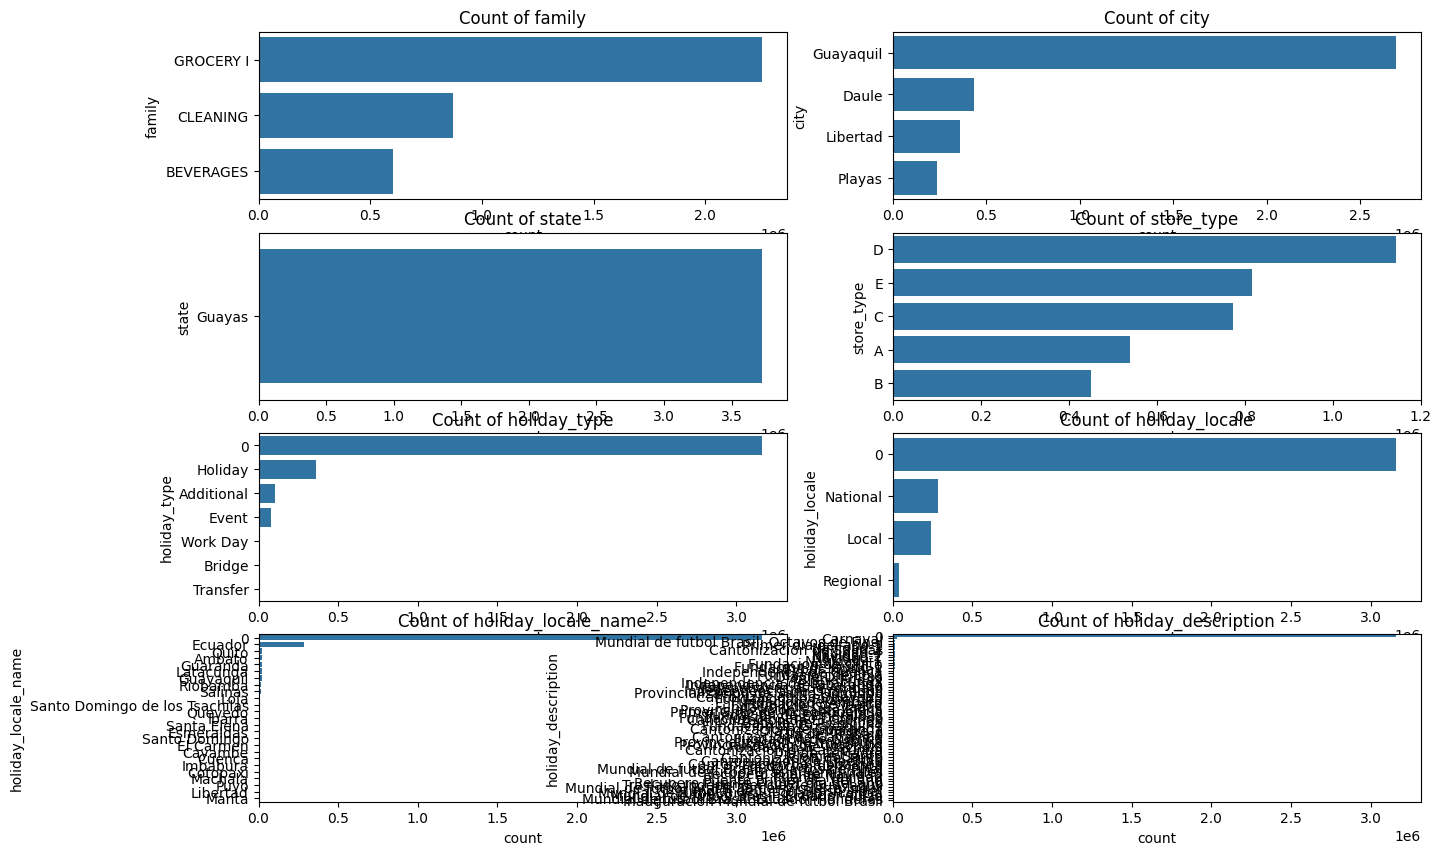

In [27]:
# Balkendiagramme für ausgewählte kategoriale Features
plt.figure(figsize=(15, 10))
for i, col in enumerate(df_train_clean.select_dtypes(include=['object'])):
    plt.subplot(4, 2, i + 1)
    sns.countplot(data=df_train_clean, y=col, order=df_train_clean[col].value_counts().index)
    plt.title(f'Count of {col}')
plt.tight_layout()
plt.show()

In [ ]:
df_train_clean.dtypes

id                       int64
date            datetime64[ns]
store_nbr                int64
item_nbr                 int64
unit_sales             float64
onpromotion               bool
is_outlier                bool
year                     int32
month                    int32
day                      int32
day_of_week              int32
family                  object
class                    int64
perishable               int64
dcoilwtico             float64
city                    object
state                   object
type                    object
cluster                  int64
transactions           float64
dtype: object

In [ ]:
df_num = df_train_clean[['store_nbr','item_nbr','unit_sales','class','perishable','dcoilwtico','cluster','transactions']]          

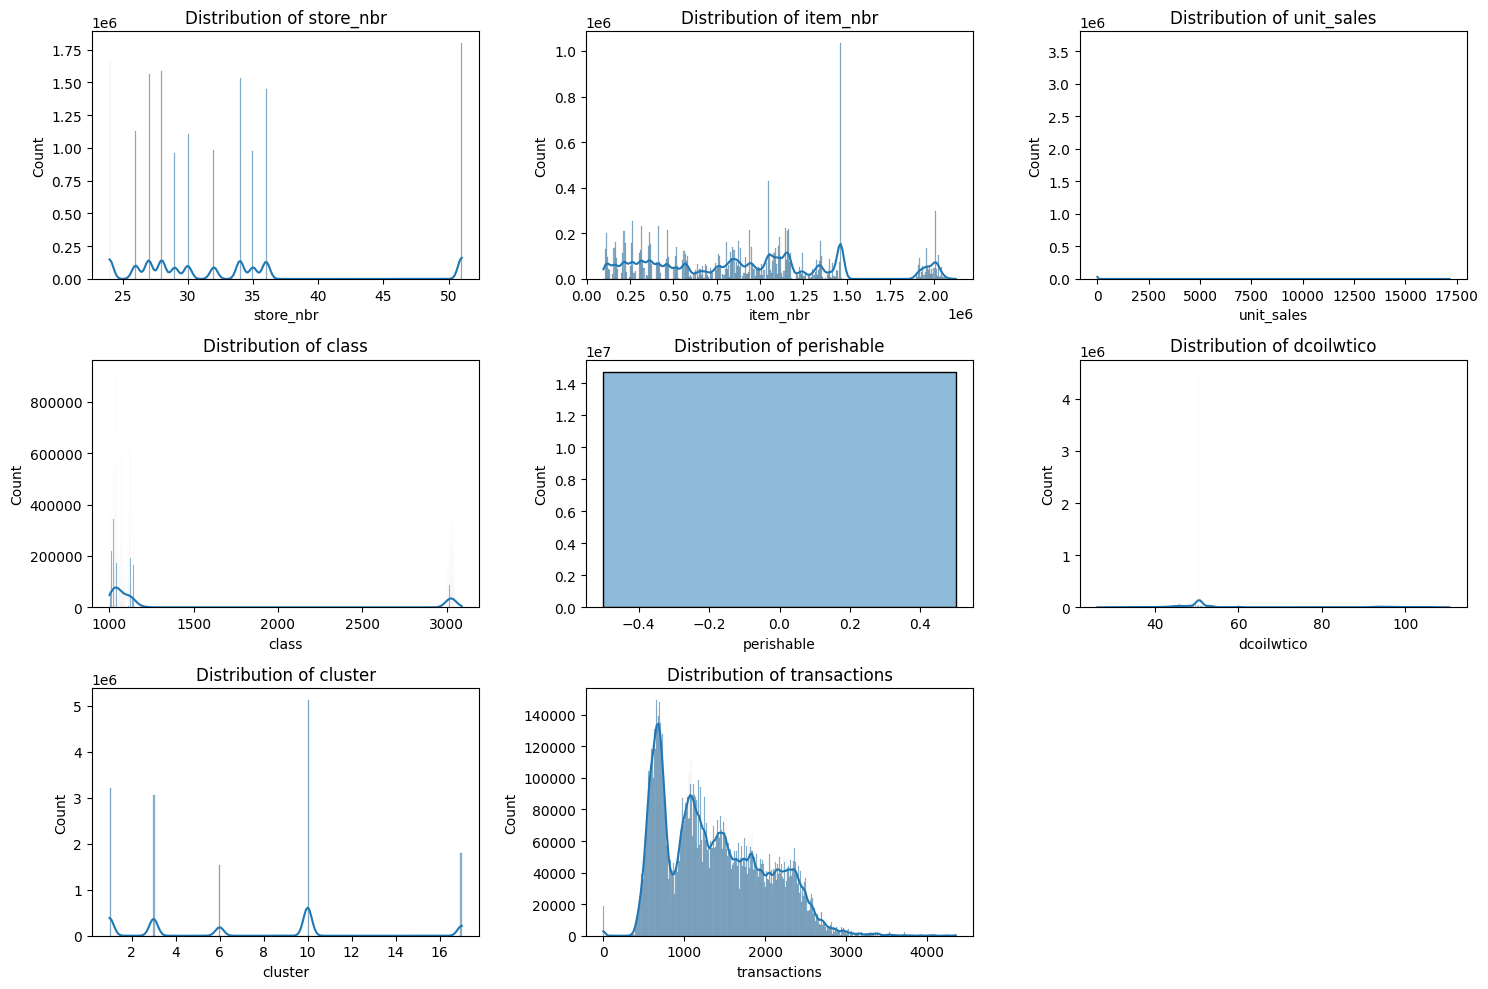

In [ ]:
# Histogramme für ausgewählte numerische Features
plt.figure(figsize=(15, 10))
for i, col in enumerate(df_num):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df_num[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

## Korrelationsmatrix

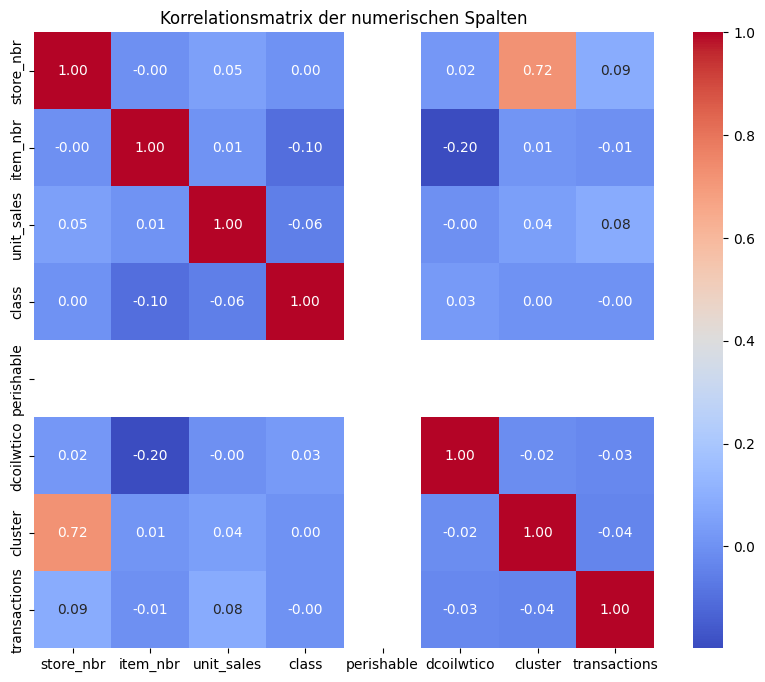

: 

In [ ]:
# Korrelationsmatrix für alle Spalten in df_num berechnen
korrelationsmatrix = df_num.corr()

# Heatmap der Korrelationsmatrix visualisieren
plt.figure(figsize=(10, 8))
sns.heatmap(korrelationsmatrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Korrelationsmatrix der numerischen Spalten')
plt.show()


## zeitliche Plots

In [ ]:
# df_num enthält Ihre numerischen Spalten
# Sie müssen df_train_clean verwenden, da dieses den 'date'-Index enthält
# Wir können die Spaltennamen aus df_num extrahieren
numerical_columns = df_num.columns

# Bestimmen der Anzahl der Plots und der Subplot-Layouts
n_cols = 2
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols  # Rundet nach oben

# Erstellen der Subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flacht das 2D-Array der Axes ab

for i, col in enumerate(numerical_columns):
    sns.lineplot(data=df_train_clean, x='date', y=col, ax=axes[i])
    axes[i].set_title(f'{col} over Time')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel(col)

# Entfernen leerer Subplots
for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
#pip freeze > requirements.txt